# PyTorch Regression and Bias-Variance Trade-off Demonstration

This notebook demonstrates simple regression using PyTorch and visualizes the bias-variance trade-off

## Section 0: Setup - Imports and Helper Functions

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Helper function to plot data and fits
def plot_regression(x_data, y_data, y_true=None, y_pred=None, title="Regression Plot"):
    """Plots the original data, true function (optional), and predictions (optional)."""
    plt.figure(figsize=(10, 6))
    # Ensure data is on CPU and converted to NumPy for plotting
    x_data_np = x_data.cpu().numpy()
    y_data_np = y_data.cpu().numpy()
    
    plt.scatter(x_data_np, y_data_np, label='Data Points', color='blue', alpha=0.7)
    
    if y_true is not None:
        y_true_np = y_true.cpu().numpy()
        # Sort for smooth line plotting if x_data is not sorted
        sorted_indices = np.argsort(x_data_np.squeeze())
        plt.plot(x_data_np[sorted_indices], y_true_np[sorted_indices], label='True Function', color='green', linewidth=2)
        
    if y_pred is not None:
        # Ensure y_pred is detached and on CPU for numpy conversion
        if isinstance(y_pred, torch.Tensor):
            y_pred_np = y_pred.detach().cpu().numpy()
        else:
            y_pred_np = y_pred # Assuming y_pred is already a numpy array
        
        # Sort for smooth line plotting if x_data is not sorted
        sorted_indices = np.argsort(x_data_np.squeeze())
        plt.plot(x_data_np[sorted_indices], y_pred_np[sorted_indices], label='Model Fit', color='red', linestyle='--', linewidth=2)
        
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.show()
    


## Section 1: Simple Linear Regression with PyTorch
This section introduces the fundamentals of building a simple linear regression model in PyTorch.

### 1.1 Generating a Toy Dataset for Simple Linear Regression
We'll start by creating a synthetic dataset. The data will follow a basic linear relationship of the form y=mx+c, with some Gaussian noise added to the y values to make the regression task more realistic. This allows us to know the "true" underlying parameters and evaluate how well our model learns them.


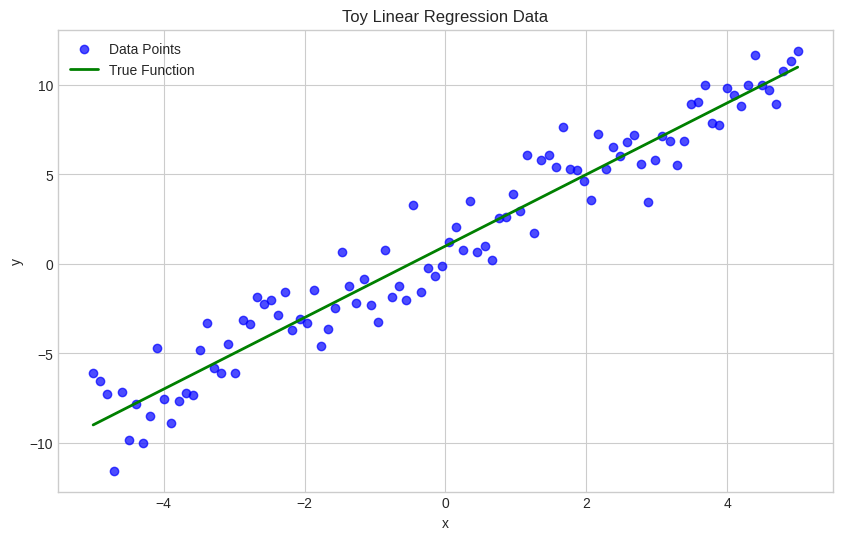

In [2]:

X_simple = torch.linspace(-5, 5, 100).unsqueeze(1)
true_slope = 2.0
true_intercept = 1.0
y_true_simple = true_slope * X_simple + true_intercept
y_simple = y_true_simple + torch.randn(X_simple.size()) * 1.5 # Add some Gaussian noise

plot_regression(X_simple, y_simple, y_true_simple, title="Toy Linear Regression Data")



### 1.2 Defining the Simple Regression Model
The model for simple linear regression is y=wx+b, where w is the weight (slope) and b is the bias (intercept). In PyTorch, this can be implemented using nn.Linear(input_features, output_features). For our case, we have one input feature (x) and one output feature (y).


In [3]:

class SimpleLinearRegression(nn.Module):
    def __init__(self):
        super(SimpleLinearRegression, self).__init__()
        # nn.Linear(input_features, output_features)
        self.linear = nn.Linear(1, 1) # One input feature (x), one output feature (y)

    def forward(self, x):
        return self.linear(x)

simple_model = SimpleLinearRegression()
print("\nSimple Linear Regression Model Structure:")
print(simple_model)



Simple Linear Regression Model Structure:
SimpleLinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)



### 1.3 Training the Model
We'll use Mean Squared Error (nn.MSELoss) as our loss function, which is appropriate for regression tasks. The optimizer will be Stochastic Gradient Descent (optim.SGD). The training loop will iterate for a fixed number of epochs, performing the forward pass, calculating the loss, performing backpropagation, and updating the model weights.


In [4]:

criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.SGD(simple_model.parameters(), lr=0.01) # Stochastic Gradient Descent

num_epochs_simple = 100
for epoch in range(num_epochs_simple):
    # Forward pass
    outputs = simple_model(X_simple)
    loss = criterion(outputs, y_simple)

    # Backward and optimize
    optimizer.zero_grad() # Zero the gradients
    loss.backward()       # Compute gradients
    optimizer.step()      # Update weights

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_simple}], Loss: {loss.item():.4f}')


Epoch [20/100], Loss: 3.9908
Epoch [40/100], Loss: 2.9689
Epoch [60/100], Loss: 2.5242
Epoch [80/100], Loss: 2.3259
Epoch [100/100], Loss: 2.2376



### 1.4 Visualizing Results and Learned Parameters
After training, we'll visualize how well our model's predictions fit the data and compare the learned parameters (w and b) to the true values.


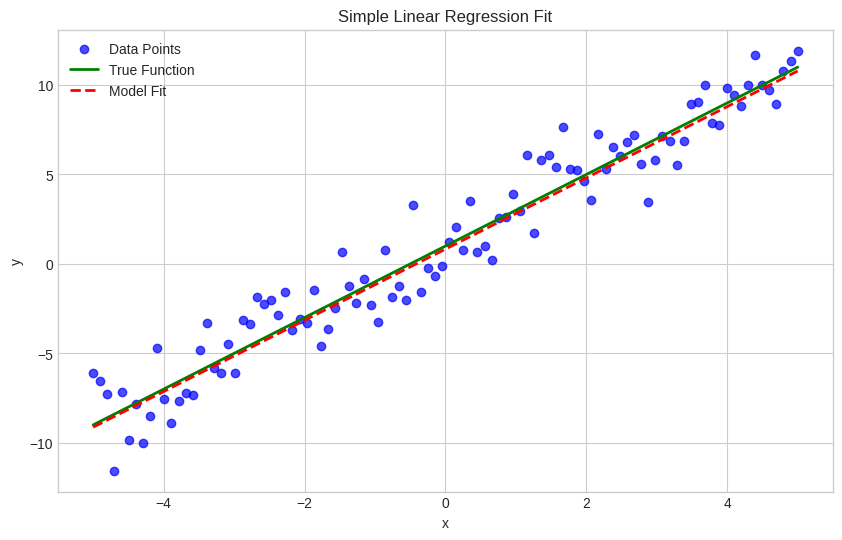


Learned parameters (Simple Linear Regression):
linear.weight: 1.991157054901123
linear.bias: 0.8284448981285095
(True slope: 2.0, True intercept: 1.0)


In [5]:

with torch.no_grad(): # We don't need to track gradients for visualization
    predicted_simple = simple_model(X_simple)
plot_regression(X_simple, y_simple, y_true_simple, predicted_simple, title="Simple Linear Regression Fit")

# Print learned parameters
print("\nLearned parameters (Simple Linear Regression):")
for name, param in simple_model.named_parameters():
    if param.requires_grad:
        # .squeeze().tolist() for cleaner print if it's a single value or simple list
        if param.data.numel() == 1:
            print(f"{name}: {param.data.item()}")
        else:
            print(f"{name}: {param.data.squeeze().tolist()}")
print(f"(True slope: {true_slope}, True intercept: {true_intercept})")



### Exercise 1: Simple Linear Regression
Modify the learning rate (lr) in the optimizer (e.g., to 0.1 or 0.001). How does this affect the training speed and final loss?
Change the number of epochs (num_epochs_simple). What happens if you train for too few or too many epochs?
Experiment with the amount of noise added to y_simple. How does more noise affect the model's ability to find the true parameters?



## Section 2: Regression with Basis Functions

Linear models can be extended to fit non-linear data by using basis functions. The core idea is to transform the input features $x$ into a new set of features $\phi(x)$ using non-linear functions, and then apply a linear model to these transformed features. The model becomes $y = \mathbf{w}^T \phi(x)$. We will use Gaussian basis functions for this demonstration.

### 2.1 Gaussian Basis Functions

A Gaussian basis function is typically of the form:
$$\phi_j(x) = \exp\left\{ -\frac{(x - \mu_j)^2}{2s^2} \right\}$$
where $\mu_j$ is the center of the $j$-th basis function and $s$ is its width (or scale). We will create a set of these functions, each centered at different points $\mu_j$ across the input range.

####  2.1 Gaussian Basis Functions Implementation


In [6]:

def gaussian_basis_functions(x, mus, s):
    """
    Computes Gaussian basis functions.
    x: input tensor (N, 1)
    mus: tensor of means for basis functions (M,) or (1, M)
    s: scalar, width of basis functions
    Returns: tensor of basis function activations (N, M)
    """
    # Ensure mus is correctly shaped for broadcasting if it's 1D
    if mus.ndim == 1:
        mus = mus.unsqueeze(0) # Makes mus (1, M) for broadcasting with (N, 1) x
    return torch.exp(-(x - mus)**2 / (2 * s**2))



### 2.2 Generating a Toy Dataset for Non-Linear Regression
To illustrate the use of basis functions, we'll generate data from a non-linear function, specifically a sine wave (y=sin(2πx)), again with some added Gaussian noise. We then preprocess the input X_nonlinear by computing the activations of our Gaussian basis functions for each input point. A bias term (a column of ones, representing ϕ_0​(x)=1) is also added to these features.


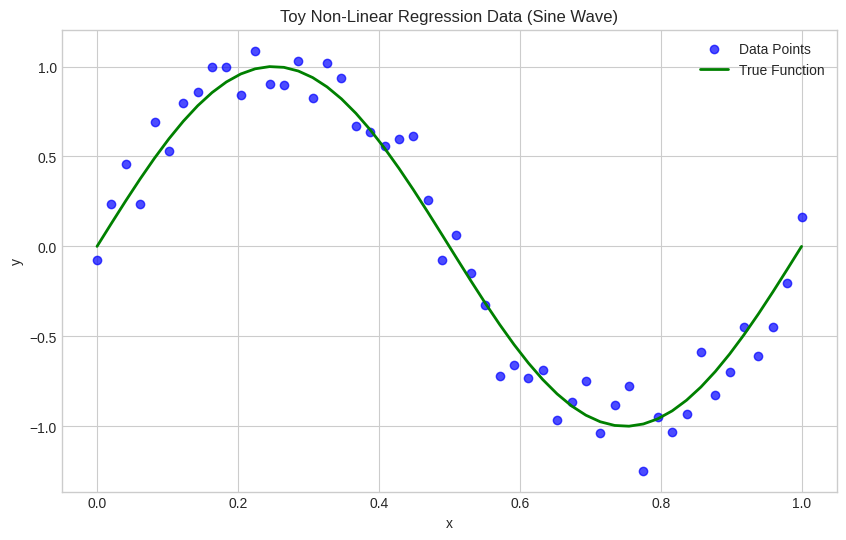

In [7]:

N_nonlinear = 50
X_nonlinear = torch.linspace(0, 1, N_nonlinear).unsqueeze(1)
y_true_nonlinear = torch.sin(2 * np.pi * X_nonlinear)
y_nonlinear = y_true_nonlinear + torch.randn(N_nonlinear, 1) * 0.2

# Define basis function parameters
num_basis_functions = 9  # M-1 in Bishop's notation (excluding bias)
# Spread mus evenly from 0 to 1
mus = torch.linspace(0, 1, num_basis_functions) # Shape (num_basis_functions,)
s_basis = 0.1 # Width of Gaussian basis functions

# Preprocess X_nonlinear using basis functions
phi_X_nonlinear_features = gaussian_basis_functions(X_nonlinear, mus, s_basis)

# Add a bias term (phi_0(x) = 1)
phi_X_nonlinear_with_bias = torch.cat([torch.ones(N_nonlinear, 1), phi_X_nonlinear_features], dim=1)
M_basis = phi_X_nonlinear_with_bias.shape[1] # Total number of basis functions including bias

plot_regression(X_nonlinear, y_nonlinear, y_true_nonlinear, title="Toy Non-Linear Regression Data (Sine Wave)")



### 2.3 Defining the Regression Model with Basis Functions
The model will take the outputs of the basis functions, ϕ(x), as its input. Since the transformation ϕ is fixed, the model itself is still a linear combination of these transformed features. The PyTorch model will then be an nn.Linear layer that takes the M_basis (total number of basis functions including bias) features as input and produces a single output. We set bias=False in this nn.Linear layer because the bias term is already incorporated into our ϕ(x) features.


In [8]:

class BasisRegressionModel(nn.Module):
    def __init__(self, num_basis_features):
        super(BasisRegressionModel, self).__init__()
        # The input to this linear layer will be the output of the basis functions
        self.linear = nn.Linear(num_basis_features, 1, bias=False) # Bias is already in phi_X

    def forward(self, phi_x): # Takes pre-computed basis features as input
        return self.linear(phi_x)

basis_model = BasisRegressionModel(M_basis)
print("\nBasis Regression Model Structure:")
print(basis_model)



Basis Regression Model Structure:
BasisRegressionModel(
  (linear): Linear(in_features=10, out_features=1, bias=False)
)



### 2.4 Training the Model with Basis Functions
The training process is similar to the simple linear regression case, but now the model operates on the pre-computed basis function features.


In [9]:

criterion_basis = nn.MSELoss()
optimizer_basis = optim.SGD(basis_model.parameters(), lr=0.1) # Increased LR for faster convergence with more features

num_epochs_basis = 500
for epoch in range(num_epochs_basis):
    outputs = basis_model(phi_X_nonlinear_with_bias)
    loss = criterion_basis(outputs, y_nonlinear)

    optimizer_basis.zero_grad()
    loss.backward()
    optimizer_basis.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs_basis}], Loss: {loss.item():.4f}')


Epoch [100/500], Loss: 0.0205
Epoch [200/500], Loss: 0.0191
Epoch [300/500], Loss: 0.0183
Epoch [400/500], Loss: 0.0177
Epoch [500/500], Loss: 0.0173



### 2.5 Visualizing Results
We plot the model's fit against the non-linear data.


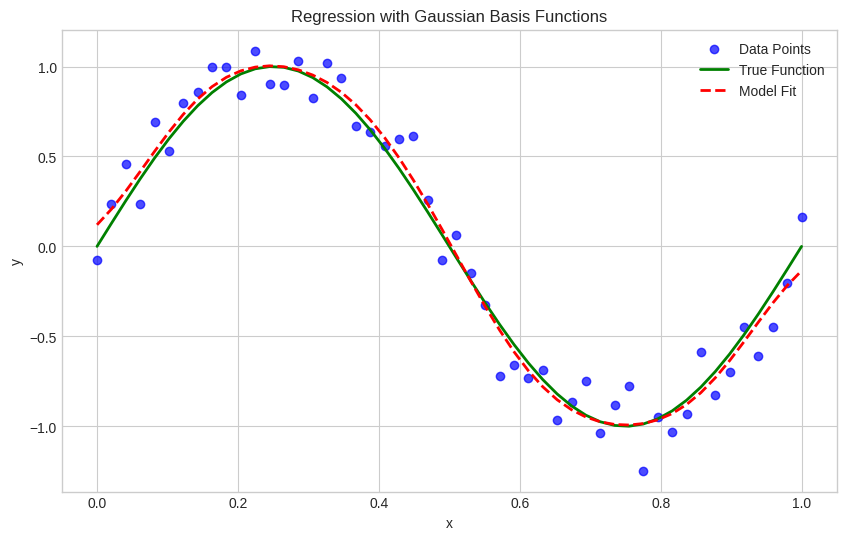

In [10]:

with torch.no_grad():
    predicted_basis = basis_model(phi_X_nonlinear_with_bias)
plot_regression(X_nonlinear, y_nonlinear, y_true_nonlinear, predicted_basis, title="Regression with Gaussian Basis Functions")


## Section 3: Bias-Variance Trade-off Demonstration

This section aims to visually and quantitatively explore the bias-variance trade-off, a fundamental concept in machine learning. We will replicate a simplified version of the demonstration (Figures 4 and 8). 

The core idea is to:
- Generate multiple (L) training datasets from a known true function h(x), with added noise.
- For each dataset, train a model. We'll use a model based on Gaussian basis functions.
- Control the model's complexity using L2 regularization (ridge regression), where the strength of regularization is determined by a parameter λ.
- Observe how the model's predictions vary across different datasets and how the average prediction compares to the true function h(x).

### 3.1 Define the true function, data generation, and parameters

The true underlying function h(x) will be h(x)=sin(2πx). Datasets are generated by sampling x values, calculating h(x), and adding Gaussian noise. We also define parameters for the number of datasets, points per dataset, noise level, basis functions, and regularization strengths. A fixed test set X_test_bv is created to evaluate all models consistently.


In [11]:

def true_func_bv(x): # Renamed to avoid conflict if any
    return torch.sin(2 * np.pi * x)

def generate_data_bv(num_points, noise_std):
    x = torch.rand(num_points, 1) # Sample x uniformly from [0, 1]
    y_true = true_func_bv(x)
    y_noisy = y_true + torch.randn(num_points, 1) * noise_std
    return x, y_noisy, y_true # Return y_true as well for potential noise calculation

# Parameters for the experiment
L_datasets = 20  # Number of datasets to generate (as requested)
N_points_bv = 25 # Number of data points per dataset
noise_std_bv = 0.3

# Basis function parameters for bias-variance
M_basis_bv_no_bias = 9 # Number of Gaussian basis functions (e.g., M-1 = 9)
mus_bv = torch.linspace(0, 1, M_basis_bv_no_bias)
s_bv = 0.15 # Width of Gaussian basis functions (adjust for better fit)
M_total_basis_bv = M_basis_bv_no_bias + 1 # Total features including bias

# Range of regularization parameters (lambda)
# Bishop uses ln(lambda), so lambda = exp(ln_lambda)
ln_lambdas = torch.tensor([-3.0, -1.0, 0.0, 1.0, 3.0]) # Fewer points for quicker demo
# ln_lambdas = torch.linspace(-5, 3, 10) # More points for a smoother curve

# Store results for plotting bias-variance curve
all_biases_sq = []
all_variances = []
# all_avg_test_errors = [] # Optional: if we want to plot test error

# Test data for evaluating bias and variance (fine grid)
X_test_bv = torch.linspace(0, 1, 100).unsqueeze(1)
phi_X_test_bv_features = gaussian_basis_functions(X_test_bv, mus_bv, s_bv)
phi_X_test_bv = torch.cat([torch.ones(X_test_bv.shape[0], 1), phi_X_test_bv_features], dim=1)
h_X_test_bv = true_func_bv(X_test_bv)



### 3.2 Experiment Loop
- For each value of $\ln(\lambda)$:
    - Generate $L$ different training datasets.
    - For each training dataset:
        - Train a BasisRegressionModel using L2 regularization.
        - The weight\_decay parameter in PyTorch optimizers (e.g., AdamW, SGD) corresponds to $\lambda$ in the L2 penalty term $2\lambda \|\mathbf{w}\|^2$ when using an average loss (such as MSE).
        - Store the predictions of each of the $L$ models on the fixed $X_\text{test}^{\text{bv}}$.
    - Compute the average prediction $\mathbb{E}_{\mathcal{D}}[f(x;\mathcal{D})]$ by averaging the $L$ predictions on $X_\text{test}^{\text{bv}}$.
    - Calculate $(\text{Bias})^2 = \operatorname{mean}_x (\mathbb{E}_{\mathcal{D}}[f(x;\mathcal{D})] - h(x))^2$.
    - Calculate $\text{Variance} = \operatorname{mean}_x (\operatorname{Var}_{\mathcal{D}}[f(x;\mathcal{D})])$, where $\operatorname{Var}_{\mathcal{D}}[f(x;\mathcal{D})]$ is the variance of predictions across the $L$ datasets for each $x$.
    - Plot the $L$ fitted curves and their average.



Training for ln(lambda) = -3.00 (lambda = 0.0498)


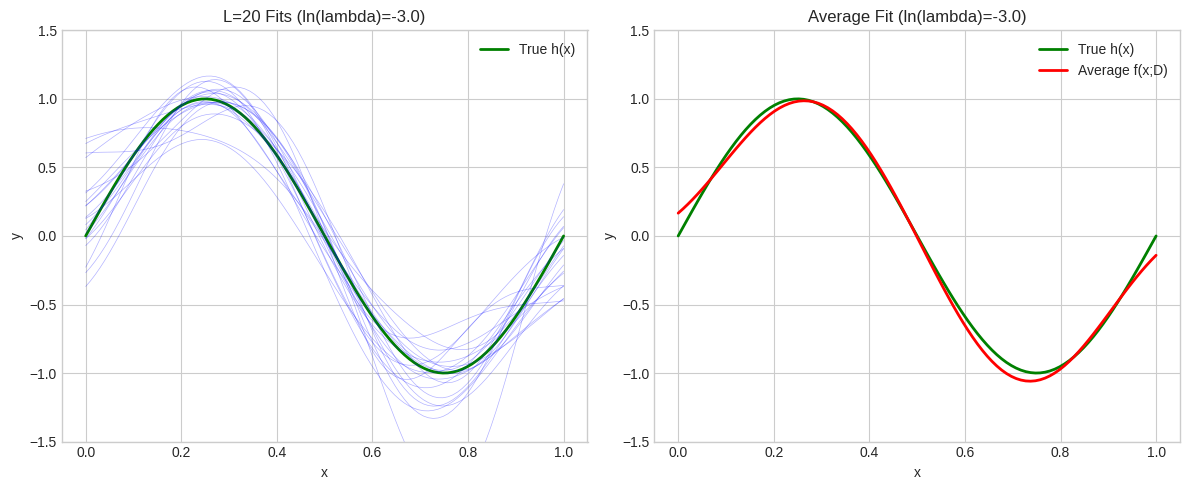

  (Bias)^2: 0.0027, Variance: 0.0298, Sum: 0.0325

Training for ln(lambda) = -1.00 (lambda = 0.3679)


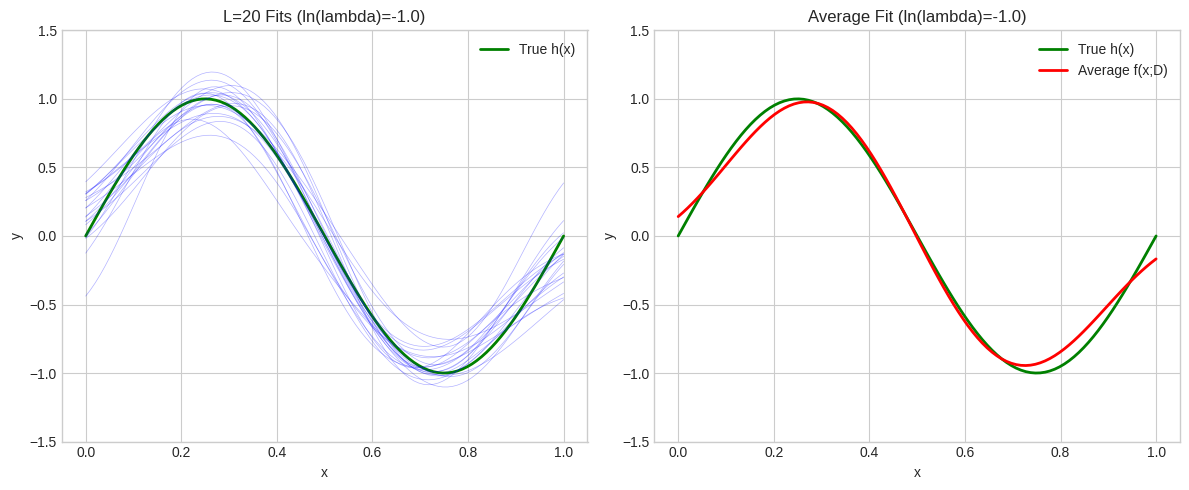

  (Bias)^2: 0.0040, Variance: 0.0162, Sum: 0.0202

Training for ln(lambda) = 0.00 (lambda = 1.0000)


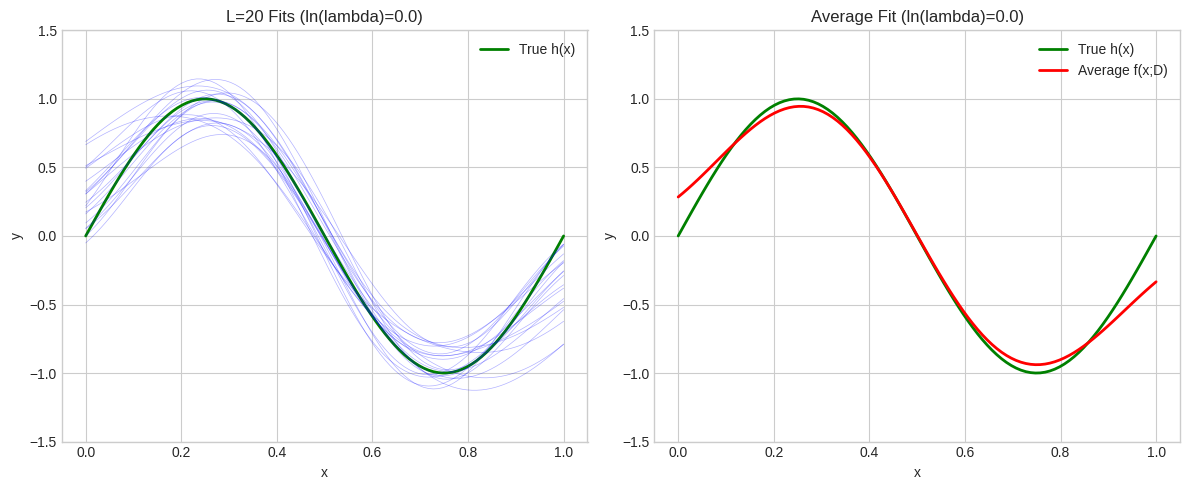

  (Bias)^2: 0.0087, Variance: 0.0192, Sum: 0.0278

Training for ln(lambda) = 1.00 (lambda = 2.7183)


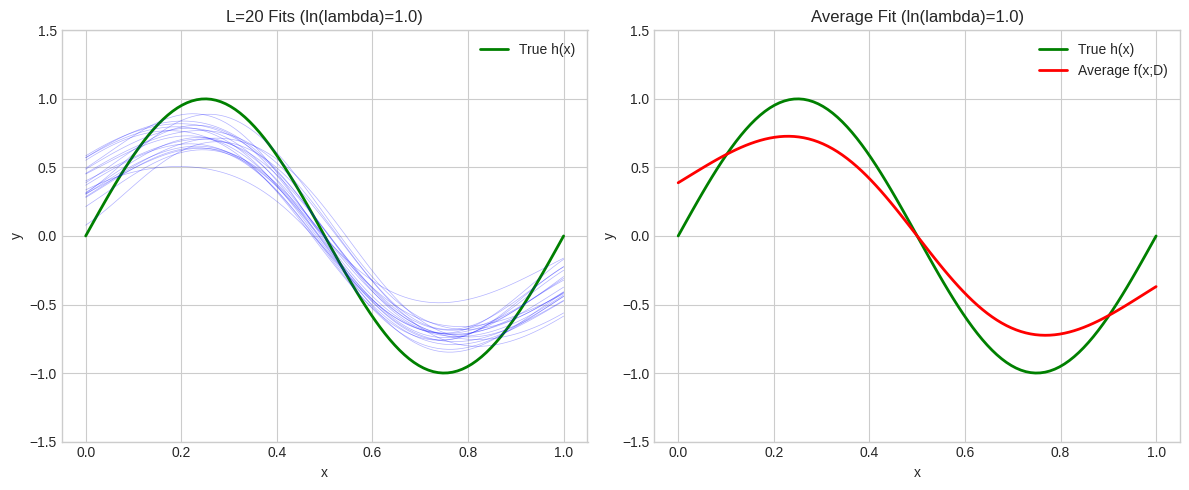

  (Bias)^2: 0.0420, Variance: 0.0087, Sum: 0.0508

Training for ln(lambda) = 3.00 (lambda = 20.0855)


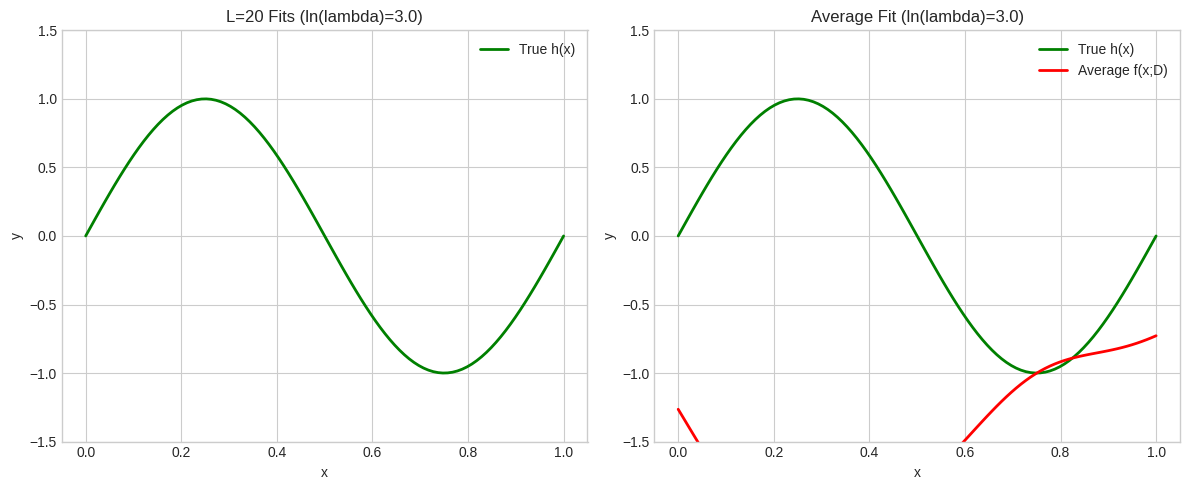

  (Bias)^2: 3.7853, Variance: 389.0269, Sum: 392.8123


In [18]:

for ln_lambda_val in ln_lambdas:
    lambda_val = torch.exp(ln_lambda_val)
    print(f"\nTraining for ln(lambda) = {ln_lambda_val.item():.2f} (lambda = {lambda_val.item():.4f})")

    predictions_on_test_for_all_datasets = [] # Store predictions on X_test_bv for each of L datasets

    # Setup plot for individual fits for current lambda
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    # Plot true function once per subplot
    sorted_indices_test_plot = np.argsort(X_test_bv.cpu().numpy().squeeze()) # Ensure it's numpy for argsort
    plt.plot(X_test_bv.cpu().numpy()[sorted_indices_test_plot], h_X_test_bv.cpu().numpy()[sorted_indices_test_plot], color='green', linewidth=2, label='True h(x)' if L_datasets > 0 else "_nolegend_")


    for l_idx in range(L_datasets):
        # Generate new dataset
        X_train_l, y_train_l, _ = generate_data_bv(N_points_bv, noise_std_bv)

        # Preprocess training data with basis functions
        phi_X_train_l_features = gaussian_basis_functions(X_train_l, mus_bv, s_bv)
        phi_X_train_l = torch.cat([torch.ones(N_points_bv, 1), phi_X_train_l_features], dim=1)

        # Define and train model
        model_bv = BasisRegressionModel(M_total_basis_bv)
        criterion_bv = nn.MSELoss()
        # Optimizer with L2 regularization (weight_decay)
        optimizer_bv = optim.AdamW(model_bv.parameters(), lr=0.1, weight_decay=lambda_val.item())

        num_epochs_bv = 200 # Fewer epochs for speed in this demo loop
        for epoch in range(num_epochs_bv):
            outputs = model_bv(phi_X_train_l)
            loss = criterion_bv(outputs, y_train_l)
            # Regularization is handled by AdamW's weight_decay
            
            optimizer_bv.zero_grad()
            loss.backward()
            optimizer_bv.step()

        # Store predictions on the fine test grid
        with torch.no_grad():
            pred_test_l = model_bv(phi_X_test_bv)
            predictions_on_test_for_all_datasets.append(pred_test_l)
            if l_idx < 20: # Plot only up to 20 fits for clarity, as requested
                plt.plot(X_test_bv.cpu().numpy()[sorted_indices_test_plot], pred_test_l.cpu().numpy()[sorted_indices_test_plot], color='blue', alpha=0.3, linewidth=0.5)

    plt.title(f'L={L_datasets} Fits (ln(lambda)={ln_lambda_val.item():.1f})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(-1.5, 1.5)
    if L_datasets > 0:
        plt.legend()

    predictions_on_test_for_all_datasets_tensor = torch.stack(predictions_on_test_for_all_datasets)
    avg_prediction_on_test = torch.mean(predictions_on_test_for_all_datasets_tensor, dim=0)

    plt.subplot(1, 2, 2)
    plt.plot(X_test_bv.cpu().numpy()[sorted_indices_test_plot], h_X_test_bv.cpu().numpy()[sorted_indices_test_plot], color='green', linewidth=2, label='True h(x)')
    plt.plot(X_test_bv.cpu().numpy()[sorted_indices_test_plot], avg_prediction_on_test.cpu().numpy()[sorted_indices_test_plot], color='red', linewidth=2, label='Average f(x;D)')
    plt.title(f'Average Fit (ln(lambda)={ln_lambda_val.item():.1f})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.ylim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()

    bias_sq = torch.mean((avg_prediction_on_test - h_X_test_bv)**2)
    variance = torch.mean(torch.var(predictions_on_test_for_all_datasets_tensor, dim=0, unbiased=False))

    all_biases_sq.append(bias_sq.item())
    all_variances.append(variance.item())

    print(f"  (Bias)^2: {bias_sq.item():.4f}, Variance: {variance.item():.4f}, Sum: {(bias_sq + variance).item():.4f}")

    
